# 比例ハザードモデルの拡張
> 
> - **標本データの抽出元によって回帰係数の値が変化する**→層別化
> - **説明変数$x$は時間が経過しても変化しない**→時間依存性共変量の取り込み
> - **標本データに区間打ち切りデータなどが存在する**→切断、区間打ち切りデータへの拡張



In [159]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# 日本語フォントを設定
font = {'family': 'IPAexGothic'}
mpl.rc('font', **font)

% matplotlib inline

---
## 層別比例ハザードモデル
結果変数に影響を与えることが既知であり、そのうちの一部の変数における効果の推定が、さほど重要でない状況を考える。これらの変数は、予備的解析で特定されていることとする。

層別比例ハザードモデルは、条件付きロジスティック回帰分析のモデルと類似している。それぞれの層で一定の値をもつすべての共変量の影響は、各層の基準ハザード関数に組み入れられる。層別変数としなかった他の説明変数の影響は、層ごとに一定の傾き、もしくは、異なる傾きをもつことを想定してモデル化される。

ここで、傾きが一定である層別比例ハザードモデルを考える。傾きが一定でない層別比例ハザードモデルは、共変量と1つとその層別変数の交互作用を指定することで、単純に構成できる。

**層$s$の比例ハザード関数**:
$$
h_{s}\left( t,X,\beta \right) = h_{s0}\left(t\right)e^{X^{\prime}\beta}
$$
ここで、$s=1,2,\cdots, S$の層があると仮定する。

**層$s$における部分尤度**: 以下の部分尤度は層別化でないものと同じである。しかし、ここでの尤度は層を表す添え字$s$を含む。<br>
層$s$における部分尤度は
$$
L_{ sp }\left( \beta  \right) =\prod _{ i=1 }^{ n_{ s } }{ { \left[ \frac { e^{ X^{ \prime  }_{ sj }\beta  } }{ \sum _{ j\in R\left( t_{ si } \right)  }{ e^{ X^{ \prime  }_{ sj }\beta  } }  }  \right]  }^{ { c }_{ si } } } 
$$
となる。

 - $n_{s}$: $s$番目の層の観測値の数
 - $t_{si}$: $s$層$i$番目の時間データ
 - $c_{si}$: 時間$t_{si}$での打ち切り
 - $R\left( t_{si} \right)$: 時間$t_{si}$、$s$番目の層のリスク集合
 - $X^{\prime}_{si} = \left( x_{i1}, x_{i2}, \cdots, x_{ip} \right)$: $p$次元の共変量ベクトル


すべての層別部分尤度は、それぞれの層の部分尤度の積であらわされ、
$$
L_{p}\left( \beta \right) = \prod _{s=1}^{S}{L_{sp}\left( \beta \right)}
$$
となる。パラメータベクトル$\beta$の層別された部分尤度における最尤推定量は、上式の対数を$p$個の未知パラメータで微分し、それが0に等しいとおいた$p$個の連立方程式を解くことによって得られる。推定された回帰係数の共分散行列の推定量は、非層別のときと同様に情報量行列の逆行列から得られる。

In [2]:
ACTG_SURVIVAL_DATASET_PATH = 'dataset/actg320.dat'
COLUMNS = ['time', 'censor', 'time_d', 'censor_d', 'tx', 'txgrp', 'start2', 'sex', 'raceth', 'ivdrug', 'hemophil', 'karnof', 'cd4', 'priorzdv', 'age']

actg_df = pd.read_csv(ACTG_SURVIVAL_DATASET_PATH, sep='\s+', header=None, index_col=0, names=COLUMNS)
actg_df.head()

,time,censor,time_d,censor_d,tx,txgrp,start2,sex,raceth,ivdrug,hemophil,karnof,cd4,priorzdv,age
1,189,0,189,0,0,1,1,1,1,1,0,100,169.0,39.0,34
2,287,0,287,0,0,1,1,2,2,1,0,90,149.5,15.0,34
3,242,0,242,0,1,2,0,1,1,1,1,100,23.5,9.0,20
4,199,0,199,0,0,1,1,1,1,1,0,90,46.0,53.0,48
5,286,0,286,0,1,2,0,1,1,3,0,90,10.0,12.0,46


In [3]:
# 層別変数はcd4細胞数の四分位点に基づいて、カテゴリ変数を構成し、それを層別変数とする。
Q1 = actg_df['cd4'].quantile(.25)
Q2 = actg_df['cd4'].quantile(.50)
Q3 = actg_df['cd4'].quantile(.75)

print(Q1)
print(Q2)
print(Q3)

actg_df['strata'] = np.zeros(actg_df.shape[0], dtype=float)
actg_df = actg_df.copy()

def add_strata(strata_value, Q1, Q2, Q3):
    q1_where = strata_value <= Q1
    q2_where = (strata_value > Q1)&(strata_value <= Q2)
    q3_where = (strata_value > Q2)&(strata_value <= Q3)
    q4_where = strata_value > Q3
    if q1_where:
        return 1
    elif q2_where:
        return 2
    elif q3_where:
        return 3
    else:
        return 4


actg_df['strata'] = actg_df['cd4'].apply(add_strata, Q1=Q1, Q2=Q2, Q3=Q3)

23.0
74.5
136.5


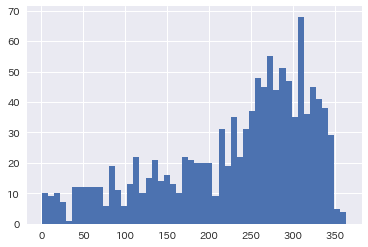

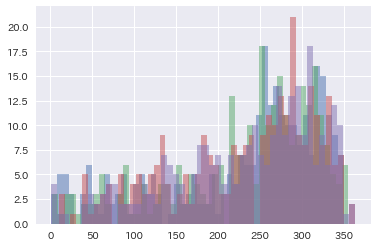

In [4]:
plt.hist(actg_df['time'], bins=50)
plt.show()

plt.hist(actg_df[actg_df['strata'] == 1]['time'], bins=50, alpha=0.5)
plt.hist(actg_df[actg_df['strata'] == 2]['time'], bins=50, alpha=0.5)
plt.hist(actg_df[actg_df['strata'] == 3]['time'], bins=50, alpha=0.5)
plt.hist(actg_df[actg_df['strata'] == 4]['time'], bins=50, alpha=0.5)
plt.show()

In [5]:
from lifelines import CoxPHFitter

x_cols = ['tx', 'ivdrug', 'karnof', 'age', 'strata']
y_cols = ['time', 'censor']

cox_ph_model = CoxPHFitter()
cox_ph_model.fit(actg_df[x_cols + y_cols], duration_col='time', event_col='censor', strata=['strata'])
cox_ph_model.summary

/Users/taiyou/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
tx,-0.675316,0.508996,0.215336,-3.136105,0.001712,-1.097366,-0.253265
ivdrug,-0.300418,0.740509,0.165681,-1.813231,0.069796,-0.625146,0.024311
karnof,-0.055657,0.945863,0.012135,-4.586308,0.000005,-0.079442,-0.031872
age,0.021720,1.021957,0.011191,1.940766,0.052287,-0.000215,0.043654


---
## 時間依存性説明変数(time-varying covariate, time-dependent covariate)
これまで、モデルの特徴量はどの時間でも一定の値であることを想定していた。しかし、特徴量が時間とともに変化することを想定し、モデル化する。



In [248]:
UIS_SURVIVAL_DATASET_PATH = 'dataset/uis.dat'
COLUMNS = ['id', 'age', 'beck', 'hercoc', 'ivhx', 'ndrugtx', 'race', 'treat', 'site', 'lot', 'time', 'censor']

uis_df = pd.read_csv(UIS_SURVIVAL_DATASET_PATH, sep='\s+', header=None, names=COLUMNS)
uis_df.head()

,id,age,beck,hercoc,ivhx,ndrugtx,race,treat,site,lot,time,censor
0,1,39,9,4,3,1,0,1,0,123,188,1
1,2,33,34,4,2,8,0,1,0,25,26,1
2,3,33,10,2,3,3,0,1,0,7,207,1
3,4,32,20,4,3,1,0,0,0,66,144,1
4,5,24,5,2,1,5,1,1,0,173,551,0


> この試験では、違法薬物使用の再発を防止するために計画された、２つの異なる居住型治療プログラム(長期滞在、短期滞在)のうちの1つが、各被験者に対して無作為に割りつけられる。被験者はいつでもこのプログラムから離れることが可能である。イベントまでの時間は自己記入方式で収集される違法薬物を再使用するまでの時間である。ここでは、治療が時間依存効果をもつかどうかを検討する。

In [249]:
def add_off_trt(ser):
    i = ser['id']
    lot = ser['lot']
    time = ser['time']

    off_trt_list = [[], [], [], []]
    ini_t = 30
    for t in np.arange(0, time, 30):
        stop_t = ini_t + t

        if stop_t > time:
            stop_t = time

        if t <= lot:
            off_trt_list[0].append(i)
            off_trt_list[1].append(t)
            off_trt_list[2].append(stop_t)
            off_trt_list[3].append(0)
        else:
            off_trt_list[0].append(i)
            off_trt_list[1].append(t)
            off_trt_list[2].append(stop_t)
            off_trt_list[3].append(1)
    
    return off_trt_list


off_trt_ser = uis_df.apply(add_off_trt, axis=1)

In [250]:
off_trt_df_list = []
for off_trt in off_trt_ser.values:
    off_trt_df = DataFrame(off_trt).T
    off_trt_df.columns = ['id', 'start', 'stop', 'off_trt']
    off_trt_df_list.append(off_trt_df)

In [251]:
off_trt_df = pd.concat(off_trt_df_list)
off_trt_df.head()

,id,start,stop,off_trt
0,1,0,30,0
1,1,30,60,0
2,1,60,90,0
3,1,90,120,0
4,1,120,150,0


In [252]:
uis_with_off_trt_df = pd.merge(off_trt_df, uis_df, on='id', how='left')
uis_with_off_trt_df.head()

,id,start,stop,off_trt,age,beck,hercoc,ivhx,ndrugtx,race,treat,site,lot,time,censor
0,1,0,30,0,39,9,4,3,1,0,1,0,123,188,1
1,1,30,60,0,39,9,4,3,1,0,1,0,123,188,1
2,1,60,90,0,39,9,4,3,1,0,1,0,123,188,1
3,1,90,120,0,39,9,4,3,1,0,1,0,123,188,1
4,1,120,150,0,39,9,4,3,1,0,1,0,123,188,1


In [259]:
fix_df = uis_with_off_trt_df[uis_with_off_trt_df['stop'] < uis_with_off_trt_df['time']]
fix_df['censor'] = 0
uis_with_off_trt_df.loc[fix_df.index, :] = fix_df.values

/Users/taiyou/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [260]:
uis_with_off_trt_df.head()

,id,start,stop,off_trt,age,beck,hercoc,ivhx,ndrugtx,race,treat,site,lot,time,censor,treat×off_trt
0,1,0,30,0,39,9,4,3,1,0,1,0,123,188,0,0
1,1,30,60,0,39,9,4,3,1,0,1,0,123,188,0,0
2,1,60,90,0,39,9,4,3,1,0,1,0,123,188,0,0
3,1,90,120,0,39,9,4,3,1,0,1,0,123,188,0,0
4,1,120,150,0,39,9,4,3,1,0,1,0,123,188,0,0


In [261]:
uis_with_off_trt_df['treat×off_trt'] = uis_with_off_trt_df['treat']*uis_with_off_trt_df['off_trt']
uis_with_off_trt_df.head()

,id,start,stop,off_trt,age,beck,hercoc,ivhx,ndrugtx,race,treat,site,lot,time,censor,treat×off_trt
0,1,0,30,0,39,9,4,3,1,0,1,0,123,188,0,0
1,1,30,60,0,39,9,4,3,1,0,1,0,123,188,0,0
2,1,60,90,0,39,9,4,3,1,0,1,0,123,188,0,0
3,1,90,120,0,39,9,4,3,1,0,1,0,123,188,0,0
4,1,120,150,0,39,9,4,3,1,0,1,0,123,188,0,0


In [262]:
uis_with_off_trt_df

,id,start,stop,off_trt,age,beck,hercoc,ivhx,ndrugtx,race,treat,site,lot,time,censor,treat×off_trt
0,1,0,30,0,39,9,4,3,1,0,1,0,123,188,0,0
1,1,30,60,0,39,9,4,3,1,0,1,0,123,188,0,0
2,1,60,90,0,39,9,4,3,1,0,1,0,123,188,0,0
3,1,90,120,0,39,9,4,3,1,0,1,0,123,188,0,0
4,1,120,150,0,39,9,4,3,1,0,1,0,123,188,0,0
5,1,150,180,1,39,9,4,3,1,0,1,0,123,188,0,1
6,1,180,188,1,39,9,4,3,1,0,1,0,123,188,1,1
7,2,0,26,0,33,34,4,2,8,0,1,0,25,26,1,0
8,3,0,30,0,33,10,2,3,3,0,1,0,7,207,0,0
9,3,30,60,1,33,10,2,3,3,0,1,0,7,207,0,1


In [263]:
import warnings
import numpy as np
import pandas as pd
from scipy import stats

from numpy import dot, exp
from numpy.linalg import solve, norm, inv
from lifelines.fitters import BaseFitter
from lifelines import CoxTimeVaryingFitter
from lifelines.utils import (
    inv_normal_cdf,
    significance_code, normalize,
    concordance_index, _get_index,
    pass_for_numeric_dtypes_or_raise, check_low_var,
    check_for_overlapping_intervals, check_complete_separation
)


class CoxTVFitter(CoxTimeVaryingFitter):
    def fit(self, df, id_col, event_col, start_col='start', stop_col='stop', show_progress=False, step_size=None):
        df = df.copy()
        if not (id_col in df and event_col in df and start_col in df and stop_col in df):
            raise KeyError("A column specified in the call to `fit` does not exist in the dataframe provided.")

        df = df.rename(columns={id_col: 'id', event_col: 'event', start_col: 'start', stop_col: 'stop'})
        df['event'] = df['event'].astype(bool)

        df = df.set_index(['id'])

        self._check_values(df.drop(["event", "stop", "start"], axis=1), df['event'])

        stop_times_events = df[["event", "stop", "start"]]
        df = df.drop(["event", "stop", "start"], axis=1)

        self._norm_mean = df.mean(0)
        self._norm_std = df.std(0)

        hazards_ = self._newton_rhaphson(normalize(df, self._norm_mean, self._norm_std), stop_times_events, show_progress=show_progress,
                                         step_size=step_size)

        self.hazards_ = DataFrame(hazards_.T, columns=df.columns, index=['coef']) / self._norm_std
        self.confidence_intervals_ = self._compute_confidence_intervals()
        self._n_examples = df.shape[0]


        self.baseline_hazard_ = self._compute_baseline_hazards(df, stop_times_events)
        self.baseline_cumulative_hazard_ = self._compute_baseline_cumulative_hazard()
        self.baseline_survival_ = self._compute_baseline_survival()

        return self

    def _compute_baseline_hazard(self, data, stops_events, name):
        unique_death_times = np.sort(stops_events['stop'].loc[stops_events['event']].unique())

        tv_df = pd.concat([data, stops_events], axis=1)

        hazard_list = []
        for t_i in unique_death_times:
            dead_set = np.unique(stops_events[(stops_events['start'] < t_i)& (t_i <= stops_events['stop'])&(stops_events['event'] == True)].index)
            d_i = dead_set.shape[0]
            risk_set = np.unique(stops_events[(stops_events['event'] == True)&(stops_events['stop'] > t_i)].index)

            sum_exp = 0
            for j in risk_set:
                if j in dead_set: continue
                X_j = tv_df[(tv_df.index == j)&(tv_df['start'] < t_i)& (t_i <= tv_df['stop'])].drop(['start', 'stop', 'event'], axis=1).values
                w = self.hazards_.loc['coef'].values
                xw_ = np.dot(X_j, w)
                sum_exp += np.exp(xw_[0])
                v = d_i / (d_i + sum_exp)

            hazard_list.append(v)

        baseline_hazard = DataFrame(hazard_list, columns=[name], index=unique_death_times).fillna(0)
        baseline_hazard[-1:] = 0.0
        return baseline_hazard

    def _compute_baseline_hazards(self, df, stop_times_events):
        return self._compute_baseline_hazard(df, stop_times_events, name='baseline hazard')

    def _compute_baseline_cumulative_hazard(self):
        return self.baseline_hazard_.cumsum()

    def _compute_baseline_survival(self):
        survival_df = exp(-self.baseline_cumulative_hazard_)
        survival_df.columns = ['baseline survival']
        return survival_df

    def predict_cumulative_hazard(self, X, times=None):
        c_0 = self.baseline_cumulative_hazard_
        col = _get_index(X)
        xw_ = np.dot(X, self.hazards_.T)
        v = np.exp(xw_)
        cumulative_hazard_ = DataFrame(np.dot(c_0, v.T), columns=col, index=c_0.index)

        if times is not None:
            # non-linear interpolations can push the survival curves above 1 and below 0.
            return cumulative_hazard_.reindex(cumulative_hazard_.index.union(times)).interpolate("index").loc[times]
        else:
            return cumulative_hazard_

    def predict_survival_function(self, X, times=None):
        return exp(-self.predict_cumulative_hazard(X, times=times))

In [264]:
x_cols = ['treat', 'off_trt', 'treat×off_trt']
y_cols = ['id', 'start', 'stop', 'censor']

cox_tv_model = CoxTVFitter()
cox_tv_model.fit(uis_with_off_trt_df[x_cols + y_cols], id_col='id', event_col='censor', start_col='start', stop_col='stop')

<lifelines.CoxTVFitter: fitted with 5215 observations, 4707 censored>

In [265]:
cox_tv_model.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
treat,-0.435790,0.646754,0.139990,-3.113004,0.001852,-0.710166,-0.161414
off_trt,0.630452,1.878459,0.158464,3.978518,0.000069,0.319868,0.941035
treat×off_trt,0.553168,1.738753,0.182662,3.028367,0.002459,0.195157,0.911179


In [223]:
uis_with_off_trt_df

,id,start,stop,off_trt,age,beck,hercoc,ivhx,ndrugtx,race,treat,site,lot,time,censor,treat×off_trt
0,1,0,30,0,39,9,4,3,1,0,1,0,123,188,0,0
1,1,30,60,0,39,9,4,3,1,0,1,0,123,188,0,0
2,1,60,90,0,39,9,4,3,1,0,1,0,123,188,0,0
3,1,90,120,0,39,9,4,3,1,0,1,0,123,188,0,0
4,1,120,150,0,39,9,4,3,1,0,1,0,123,188,0,0
5,1,150,180,1,39,9,4,3,1,0,1,0,123,188,0,1
6,1,180,188,1,39,9,4,3,1,0,1,0,123,188,1,1
7,2,0,26,0,33,34,4,2,8,0,1,0,25,26,1,0
8,3,0,30,0,33,10,2,3,3,0,1,0,7,207,0,0
9,3,30,60,1,33,10,2,3,3,0,1,0,7,207,0,1


In [246]:
X0 = uis_with_off_trt_df[(uis_with_off_trt_df['id'] == 1)&(uis_with_off_trt_df['off_trt'] == 0)][x_cols].values
X1 = uis_with_off_trt_df[(uis_with_off_trt_df['id'] == 1)&(uis_with_off_trt_df['off_trt'] == 1)][x_cols].values
print(cox_tv_model.predict_survival_function(X0, [120]))
print(cox_tv_model.predict_survival_function(X1, [150]))

            0         1         2         3         4
120  0.002776  0.002776  0.002776  0.002776  0.002776
                0             1
150  1.781068e-10  1.781068e-10


In [247]:
print(1.781068/np.exp(1))

0.655218300528


In [245]:
print(DataFrame(survival_list, index=TIME_LIST).loc[148, 0])
print(DataFrame(survival_list, index=TIME_LIST).loc[151, 0])

0.00103761022653
1.29075008846e-10


In [243]:
print(1.2907500884608755/np.exp(1))

0.474840421235


In [205]:
TIME_LIST = cox_tv_model.baseline_hazard_.index
survival_list = []

for t in TIME_LIST:
    X = uis_with_off_trt_df[(uis_with_off_trt_df.id == 1)&(uis_with_off_trt_df['start'] <= t)&(uis_with_off_trt_df['stop'] > t)]
    if X.empty:
        survival_list.append(0)
        continue
    X = X[x_cols].values
    survival_df = cox_tv_model.predict_survival_function(X, [t])
    survival_list.append(survival_df.iloc[0, 0])

In [215]:
X = uis_with_off_trt_df[(uis_with_off_trt_df.id == 1)&(uis_with_off_trt_df['off_trt'] == 1)][x_cols].values
survival_df2 = cox_tv_model.predict_survival_function(X, TIME_LIST)

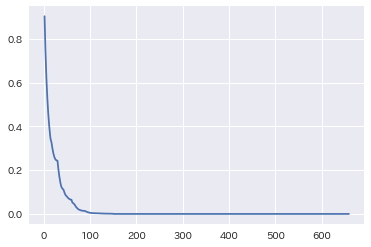

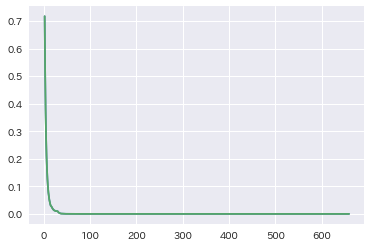

In [216]:
survival_df = DataFrame(survival_list, index=TIME_LIST)
survival_df.plot(legend=False)
survival_df2.plot(legend=False)
plt.show()

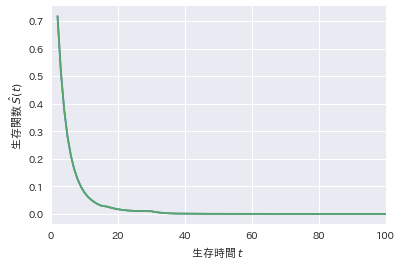

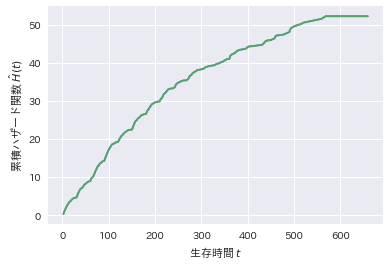

In [154]:
test_df = uis_with_off_trt_df[(uis_with_off_trt_df.id == 1)&(uis_with_off_trt_df.off_trt == 1)][x_cols]

survival_df = cox_tv_model.predict_survival_function(test_df)
survival_df.plot(legend=False)
plt.ylabel("生存関数 $\hat{S}(t)$")
plt.xlabel("生存時間 $t$")
plt.xlim(0, 100)
plt.show()

cum_hazard_df = cox_tv_model.predict_cumulative_hazard(test_df)
cum_hazard_df.plot(legend=False)
plt.ylabel("累積ハザード関数 $\hat {H}(t)$")
plt.xlabel("生存時間 $t$")
plt.show()

In [147]:
from lifelines import CoxTimeVaryingFitter

x_cols = ['treat', 'off_trt', 'treat×off_trt']
y_cols = ['id', 'start', 'stop', 'censor']

cox_tv_model = CoxTimeVaryingFitter()
cox_tv_model.fit(uis_with_off_trt_df[x_cols + y_cols], id_col='id', event_col='censor', start_col='start', stop_col='stop')

<lifelines.CoxTimeVaryingFitter: fitted with 5215 observations, 4707 censored>

In [148]:
cox_tv_model.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
treat,-0.435790,0.646754,0.139990,-3.113004,0.001852,-0.710166,-0.161414
off_trt,0.630452,1.878459,0.158464,3.978518,0.000069,0.319868,0.941035
treat×off_trt,0.553168,1.738753,0.182662,3.028367,0.002459,0.195157,0.911179
